# Phân tích tương quan giữa IF truyền thống và DeltaF1 (Baseline 1 – Influence Function truyền thống)


## Mục đích

- Đánh giá **độ phù hợp (faithfulness)** của phương pháp Influence Function truyền thống (Baseline 1) bằng cách:
  - So sánh điểm ảnh hưởng ước lượng (`influence_score_traditional`) với sự thay đổi hiệu suất thực tế (`DeltaF1`) khi can thiệp vào dữ liệu train.
- Kiểm tra:
  - Liệu IF truyền thống có tương quan cùng chiều hoặc ngược chiều với DeltaF1 hay không.
  - Mức độ ý nghĩa thống kê của mối tương quan này (thông qua Spearman’s rho và p-value).
- Kết quả dùng để:
  - So sánh với phương pháp IF* đề xuất.
  - Đưa ra nhận xét xem Baseline 1 có phải là một ước lượng tốt cho ảnh hưởng thực tế hay không.



## Đầu vào

1. Tham số cấu hình

- `drive_base_path`  
  Thư mục gốc trên Google Drive:
  - `'/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep'`.

- `output_dir`  
  Thư mục chứa các file kết quả matching và faithfulness:
  - `os.path.join(drive_base_path, 'matching_results')`.

- Danh sách file cần phân tích: `faithfulness_files_to_analyze`  
  Mỗi phần tử gồm:
  - Tên mô tả:
    - `"ParaVE Test (Baseline 1 - IF Traditional)"`
    - `"GramVar Test (Baseline 1 - IF Traditional)"`
  - Đường dẫn file JSON đầu vào (đã được tính sẵn ở bước trước):
    - `faithfulness_scores_baseline1_traditional_parave_test.json`
    - `faithfulness_scores_baseline1_traditional_gramvar_test.json`
  - Đường dẫn file ảnh biểu đồ đầu ra:
    - `correlation_plot_baseline1_traditional_parave.png`
    - `correlation_plot_baseline1_traditional_gramvar.png`

2. Nội dung các file JSON đầu vào

- Mỗi file `faithfulness_scores_baseline1_traditional_*.json` là một danh sách các phần tử:
  - `result`:
    - `result['test_sample']`: thông tin mẫu test.
    - `result['neighbors']`: danh sách các láng giềng train, trong đó mỗi `neighbor` chứa:
      - `influence_score_traditional`: giá trị IF truyền thống (Baseline 1) cho cặp (train, test).
      - `DeltaF1`: chênh lệch F1 đo được sau khi cập nhật mô hình bằng mẫu train đó.
      - Có thể kèm thêm các trường thông tin khác (text, verb_name, v.v.), nhưng không dùng trong bước phân tích này.

3. Thư viện sử dụng

- `json`, `os`
- `pandas as pd`
- `scipy.stats` (tính Spearman’s rho và p-value)
- `matplotlib.pyplot as plt`
- `seaborn as sns`
- `tqdm.auto.tqdm` (hiển thị tiến trình, dù ở đây chủ yếu là log vòng lặp)

## Đầu ra

1. Thông số tương quan Spearman

- Với mỗi bộ:
  - `ParaVE Test (Baseline 1 - IF Traditional)`
  - `GramVar Test (Baseline 1 - IF Traditional)`
- Script in ra:
  - Số lượng cặp `(IF_traditional, DeltaF1)`:
    - Ví dụ: `"-> Đã trích xuất N cặp (IF_traditional, DeltaF1)."`
  - Hệ số tương quan Spearman:
    - `rho` (correlation).
  - Giá trị `p-value`.
  - Nhận xét:
    - Nếu `p_value < 0.05`:
      - Mối tương quan có ý nghĩa thống kê.
    - Nếu `p_value >= 0.05`:
      - Mối tương quan không có ý nghĩa thống kê.

2. Biểu đồ scatter + đường hồi quy

- Hai file ảnh đầu ra (một cho mỗi tập):
  - `correlation_plot_baseline1_traditional_parave.png`
  - `correlation_plot_baseline1_traditional_gramvar.png`
- Nội dung biểu đồ:
  - Trục x:
    - `IF_traditional` (giá trị Influence Function truyền thống).
  - Trục y:
    - `DeltaF1` (sự thay đổi F1 thực tế).
  - Scatter plot:
    - Mỗi điểm là một cặp (train neighbor, test) với:
      - x = `influence_score_traditional`.
      - y = `DeltaF1`.
  - Đường hồi quy tuyến tính:
    - Vẽ bằng `sns.regplot` (chỉ đường, không vẽ lại scatter).
  - Đường tham chiếu:
    - `plt.axhline(0, ...)` (ngang qua 0 trên trục DeltaF1).
    - `plt.axvline(0, ...)` (dọc qua 0 trên trục IF_traditional).

3. DataFrame trung gian (không lưu ra file nhưng có thể sử dụng)

- Biến `df`:
  - Các cột:
    - `'IF_traditional'`
    - `'DeltaF1'`
  - Dùng để tính Spearman và làm input cho seaborn.

## Quy trình

### Bước 1: Cấu hình và danh sách file cần phân tích

- Đặt `drive_base_path`, `output_dir`.
- Khởi tạo `faithfulness_files_to_analyze`:
  - Chỉ định rõ file JSON đầu vào và file ảnh đầu ra tương ứng cho từng bộ dữ liệu.

### Bước 2: Hàm trích xuất dữ liệu

#### Hàm `extract_correlation_data(json_file)`

- Mục đích:
  - Đọc một file JSON kết quả faithfulness và trích ra các cặp:
    - `(IF_traditional, DeltaF1)`.

- Các bước:
  1. Mở file JSON:
     - Dùng `json.load`.
     - Nếu file không tồn tại:
       - In lỗi và trả về danh sách rỗng.
  2. Khởi tạo `data_pairs = []`.
  3. Với mỗi `result` trong dữ liệu:
     - Lặp qua `result['neighbors']`.
     - Nếu `neighbor` có đủ:
       - `'influence_score_traditional'`
       - `'DeltaF1'`
     - Thêm vào `data_pairs` một dict:
       - `{'IF_traditional': neighbor['influence_score_traditional'], 'DeltaF1': neighbor['DeltaF1']}`.
  4. Trả về `data_pairs`.

### Bước 3: Vòng lặp phân tích cho từng bộ dữ liệu

- Với mỗi bộ `(name, input_file, plot_file)` trong `faithfulness_files_to_analyze`:

  1. In tên bộ đang phân tích.
  2. Gọi `extract_correlation_data(input_file)`:
     - Lấy toàn bộ cặp `(IF_traditional, DeltaF1)`.
     - Nếu danh sách rỗng:
       - In thông báo và bỏ qua bộ này.
  3. Tạo DataFrame:
     - `df = pd.DataFrame(all_pairs)`.
     - In số lượng cặp đã trích xuất.

### Bước 4: Tính Spearman Correlation

- Xử lý dữ liệu:
  1. Thay các giá trị `inf`/`-inf` bằng NaN:
     - `df = df.replace([float('inf'), float('-inf')], float('nan'))`.
  2. Loại các dòng chứa NaN:
     - `df = df.dropna()`.

- Kiểm tra:
  - Nếu số lượng dòng < 2:
    - Không đủ dữ liệu để tính Spearman → bỏ qua.

- Tính Spearman:
  - `correlation, p_value = scipy.stats.spearmanr(df['IF_traditional'], df['DeltaF1'])`.

- In kết quả:
  - `rho = correlation`.
  - `p_value`.
  - Đánh giá ý nghĩa thống kê dựa trên ngưỡng `0.05`.

### Bước 5: Vẽ biểu đồ Scatter Plot + Regression Line

- Dùng matplotlib và seaborn:

  1. Khởi tạo figure:
     - `plt.figure(figsize=(10, 6))`.
  2. Vẽ scatter:
     - `sns.scatterplot(data=df, x='IF_traditional', y='DeltaF1', alpha=0.5)`.
  3. Vẽ đường hồi quy:
     - `sns.regplot(data=df, x='IF_traditional', y='DeltaF1', scatter=False, color='red', line_kws={'linestyle':'--'})`.
  4. Đặt tiêu đề và nhãn trục:
     - `plt.title(...)`.
     - `plt.xlabel('IF Truyền thống (Ước lượng Baseline 1)')`.
     - `plt.ylabel('DeltaF1 (Sự thật)')`.
  5. Thêm grid và đường tham chiếu:
     - `plt.grid(True)`.
     - `plt.axhline(0, ...)`.
     - `plt.axvline(0, ...)`.
  6. Lưu biểu đồ:
     - `plt.savefig(plot_file, dpi=300, bbox_inches='tight')`.
     - In thông báo đường dẫn.
  7. Hiển thị:
     - `plt.show()`.

### Bước 6: Kết thúc

- Sau khi xử lý cả hai bộ, in:
  - `"--- Phân tích (BASELINE 1) hoàn tất! ---"`.

--- Bắt đầu phân tích Tương quan Faithfulness (BASELINE 1) ---

ĐANG PHÂN TÍCH: ParaVE Test (Baseline 1 - IF Traditional)
 -> Đã trích xuất 699 cặp (IF_traditional, DeltaF1).

--- KẾT QUẢ TƯƠNG QUAN SPEARMAN (BASELINE 1) ---
Hệ số tương quan (rho): 0.0958
P-value: 0.0112
 -> Mối tương quan này có ý nghĩa thống kê (p < 0.05).
 -> Đã lưu biểu đồ phân tích vào: /content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/matching_results/correlation_plot_baseline1_traditional_parave.png


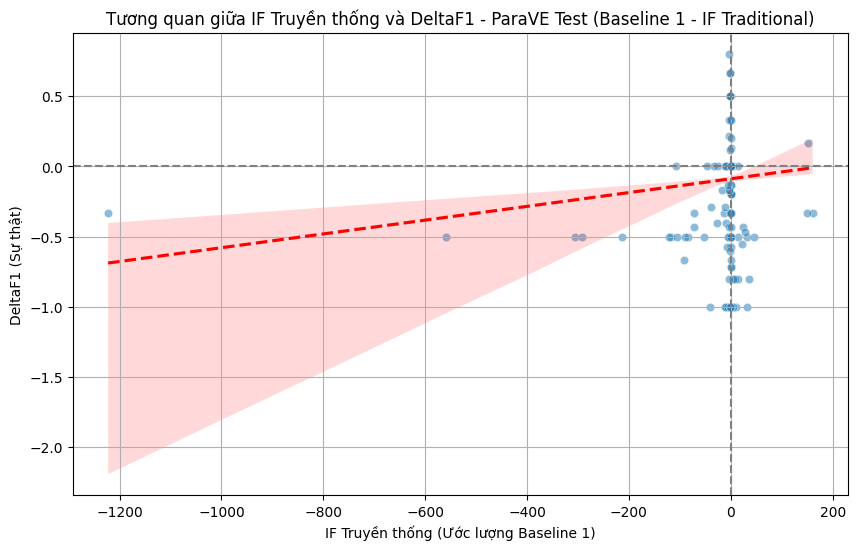


ĐANG PHÂN TÍCH: GramVar Test (Baseline 1 - IF Traditional)
 -> Đã trích xuất 1711 cặp (IF_traditional, DeltaF1).

--- KẾT QUẢ TƯƠNG QUAN SPEARMAN (BASELINE 1) ---
Hệ số tương quan (rho): 0.1241
P-value: 0.0000
 -> Mối tương quan này có ý nghĩa thống kê (p < 0.05).
 -> Đã lưu biểu đồ phân tích vào: /content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/matching_results/correlation_plot_baseline1_traditional_gramvar.png


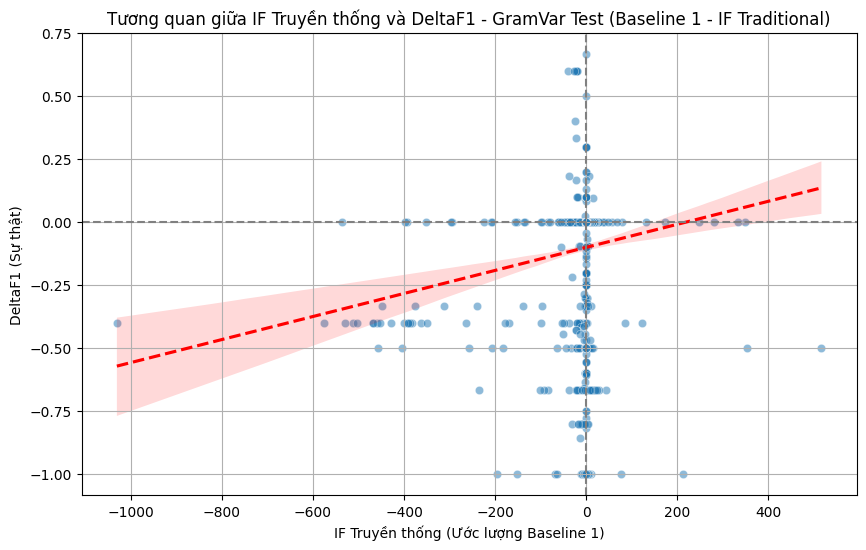


--- Phân tích (BASELINE 1) hoàn tất! ---


In [ ]:
# --- CÀI ĐẶT THƯ VIỆN ---
!pip install scipy matplotlib seaborn pandas

import json
import os
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# --- 1. CẤU HÌNH ---
drive_base_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep'
output_dir = os.path.join(drive_base_path, 'matching_results')

# *** CẤU HÌNH: Danh sách file để phân tích (BASELINE 1 - IF TRUYỀN THỐNG) ***
faithfulness_files_to_analyze = [
    (
        "ParaVE Test (Baseline 1 - IF Traditional)",
        os.path.join(output_dir, 'faithfulness_scores_baseline1_traditional_parave_test.json'), # File đầu vào MỚI
        os.path.join(output_dir, 'correlation_plot_baseline1_traditional_parave.png') # File biểu đồ MỚI
    ),
    (
        "GramVar Test (Baseline 1 - IF Traditional)",
        os.path.join(output_dir, 'faithfulness_scores_baseline1_traditional_gramvar_test.json'), # File đầu vào MỚI
        os.path.join(output_dir, 'correlation_plot_baseline1_traditional_gramvar.png') # File biểu đồ MỚI
    )
]

# --- 2. HÀM XỬ LÝ ---

def extract_correlation_data(json_file):
    """
    Trích xuất các cặp (IF_traditional, DeltaF1) từ file kết quả.
    """
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"LỖI: Không tìm thấy file {json_file}")
        return []

    data_pairs = []
    for result in data:
        for neighbor in result['neighbors']:
            # *** Tìm key 'influence_score_traditional' ***
            if 'influence_score_traditional' in neighbor and 'DeltaF1' in neighbor:
                data_pairs.append({
                    'IF_traditional': neighbor['influence_score_traditional'], # Key MỚI
                    'DeltaF1': neighbor['DeltaF1']
                })
    return data_pairs

# --- 3. THỰC THI PHÂN TÍCH ---
if __name__ == "__main__":

    print("--- Bắt đầu phân tích Tương quan Faithfulness (BASELINE 1) ---")

    for name, input_file, plot_file in faithfulness_files_to_analyze:

        print(f"\n=================================================")
        print(f"ĐANG PHÂN TÍCH: {name}")
        print(f"=================================================")

        # 1. Trích xuất dữ liệu
        all_pairs = extract_correlation_data(input_file)
        if not all_pairs:
            print("Không có dữ liệu để phân tích. Bỏ qua.")
            continue

        df = pd.DataFrame(all_pairs)
        print(f" -> Đã trích xuất {len(df)} cặp (IF_traditional, DeltaF1).")

        # 2. Tính toán Spearman Correlation
        try:
            # Lọc bỏ các giá trị NaN hoặc Inf nếu có
            df = df.replace([float('inf'), float('-inf')], float('nan')).dropna()

            if len(df) < 2:
                print("Không đủ dữ liệu (ít hơn 2) để tính tương quan.")
                continue

            # Tính Spearman trên cột 'IF_traditional'
            correlation, p_value = scipy.stats.spearmanr(df['IF_traditional'], df['DeltaF1'])

            print("\n--- KẾT QUẢ TƯƠNG QUAN SPEARMAN (BASELINE 1) ---")
            print(f"Hệ số tương quan (rho): {correlation:.4f}")
            print(f"P-value: {p_value:.4f}")

            if p_value < 0.05:
                print(" -> Mối tương quan này có ý nghĩa thống kê (p < 0.05).")
            else:
                print(" -> Mối tương quan này KHÔNG có ý nghĩa thống kê (p >= 0.05).")

        except Exception as e:
            print(f"Lỗi khi tính Spearman: {e}")
            continue

        # 3. Vẽ biểu đồ Scatter Plot
        try:
            plt.figure(figsize=(10, 6))

            # Vẽ biểu đồ với x='IF_traditional'
            sns.scatterplot(data=df, x='IF_traditional', y='DeltaF1', alpha=0.5)
            sns.regplot(data=df, x='IF_traditional', y='DeltaF1', scatter=False, color='red', line_kws={'linestyle':'--'})

            plt.title(f'Tương quan giữa IF Truyền thống và DeltaF1 - {name}')
            plt.xlabel('IF Truyền thống (Ước lượng Baseline 1)')
            plt.ylabel('DeltaF1 (Sự thật)')
            plt.grid(True)
            plt.axhline(0, color='grey', linestyle='--')
            plt.axvline(0, color='grey', linestyle='--')

            # Lưu biểu đồ
            plt.savefig(plot_file, dpi=300, bbox_inches='tight')
            print(f" -> Đã lưu biểu đồ phân tích vào: {plot_file}")
            plt.show() # Hiển thị plot trong Colab

        except Exception as e:
            print(f"Lỗi khi vẽ biểu đồ: {e}")

    print("\n--- Phân tích (BASELINE 1) hoàn tất! ---")
